In [1]:
from helpers import toWei, fromWei, UsdEthConverter, Market

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

usd = UsdEthConverter(162, 2) # $162 per ETH, round to 3 digits

In [2]:
params = {
    # 'price_floor_human':    0, # ETH per CMT.
    
    'spread':               150,
    # Create significant barrier to buying equal voting power without using price_floor. Also,
    # create steeper incentive to support early.
    
    'list_reward':          toWei(usd.toEth(2.0), 'CMT'),
    # $2.00 listing fee
    # Large enough to feel non-trivial as a fraction of whole CMT, 
    # but small enough that list rewards alone can't be easily used to get much CMT.
    
    'stake':                toWei(20, 'CMT'),
    # This one's tricky. Too high and we prevent community participation in votes and limit our own
    # voting power. Too low and we create attack risk* (Actually I'm becoming less convinced this statement
    # is true. Lower stake means its easier for an attacker to get voting power, but it also should broaden
    # the base of good actors who can vote. Lower stake also increases our voting power.)
    
    'backend_payment':      5, # percent
    # This could be 0 since the money's fake and Datatrust doesn't need it, but
    # we could also leave at 5 just to reflect the setting we'd choose for ffa-mainnet. Another reason
    # to leave > 0 is this becomes a source of ETH income to pump back in to market to maintain control
    # without having to go to the faucet.
    
    'maker_payment':        50, # percent. 
    # Increased from initial skynet deployment which had it at 30. 
    # Reasoning is it takes real effort to determine and upload a file that gets used.
    # Compensate for fact that ETH is fake (but still kinda motivating like game points) and
    # give some extra to the makers.
    
    # reserve payment:      100 - backend_payment - maker_payment
    
    'cost_per_byte':        toWei(1e-8, 'ETH'), # 1 ETH for 100MB
    # A scan through some Kaggle datasets, the size of videos, photos, and sound files, and came
    # up with 100MB as a reference listing size. Let's make buying this reference 1 ETH. You can 
    # easily get 3 ETHs from the faucet and buy 3 things.
}

In [3]:
# Convert human readable floor to units used by market codebase
params['price_floor'] = 5e5 # wei per billion CMT-wei
params['reserve_payment'] = 100 - params['backend_payment'] - params['maker_payment']

## Set up market with 3 creators each investing $166

In [16]:
total_creator_usd = 500
n_creators = 3
creator_usd = total_creator_usd/n_creators
##################

m = Market(params)
m.market_total += toWei(1e-3, 'CMT')

for i in range(3):
    print (f"Supporter {i+1} pays ${usd.fromEth(m.get_human_support_price())} per CMT")
    m.support(usd.toEth(creator_usd))
    
print ("\n")
print (f"Market reserve is {fromWei(m.reserve, 'ETH')} ETH (${usd.fromEth(fromWei(m.reserve, 'ETH'))})")
print (f"Market tokens is {round(fromWei(m.market_total, 'CMT'), 2)} CMT")
print (f"CMT withdraw price is ${usd.fromEth(m.get_withdraw_price())}")
       
CREATOR_BLOCK_SIZE = m.market_total
print (f"CREATOR_BLOCK_SIZE is {CREATOR_BLOCK_SIZE}")

Supporter 1 pays $0.08 per CMT
Supporter 2 pays $0.2 per CMT
Supporter 3 pays $0.25 per CMT


Market reserve is 3.09 ETH ($500.58)
Market tokens is 3539.46 CMT
CMT withdraw price is $0.14
CREATOR_BLOCK_SIZE is 3.5394568601090004e+21


## Scenario: simple sequence of supporting, listing, buying

In [5]:
iters = 10

support_prices_usd = np.zeros(iters)
withdraw_prices_usd = np.zeros(iters)

support_usd = 5.0
buy_mb = 20.0

for i in range(iters):
    m.support(usd.toEth(support_usd))
    m.list()
    for j in range(5):
        m.buy(buy_mb)
    
    support_prices_usd[i] = usd.fromEth(m.get_human_support_price())
    withdraw_prices_usd[i] = usd.fromEth(m.get_withdraw_price())

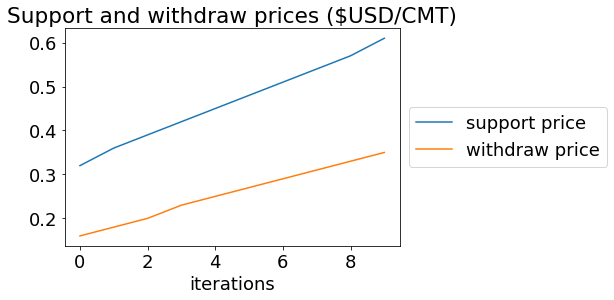

In [6]:
plt.rc('font', size=18)
fig, ax = plt.subplots()

x = np.arange(0, iters, 1)
ax.plot(x, support_prices_usd)
ax.plot(x, withdraw_prices_usd)
ax.legend(['support price', 'withdraw price'], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel='iterations', title='Support and withdraw prices ($USD/CMT)')
plt.show()

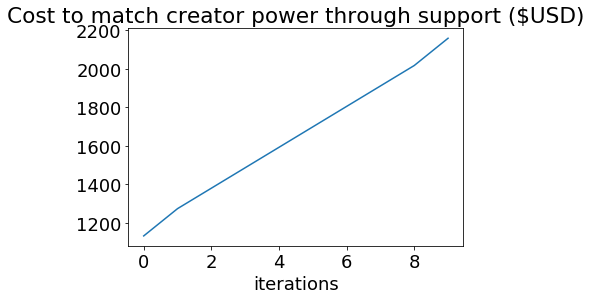

In [20]:
costs_to_match_creator = fromWei(CREATOR_BLOCK_SIZE, 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_match_creator)
ax.set(xlabel='iterations', title='Cost to match creator power through support ($USD)')
plt.show()

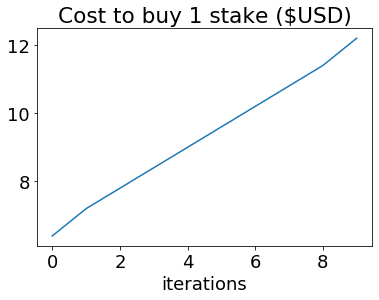

In [22]:
costs_to_stake = fromWei(params['stake'], 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_stake)
ax.set(xlabel='iterations', title='Cost to buy 1 stake ($USD)')
plt.show()

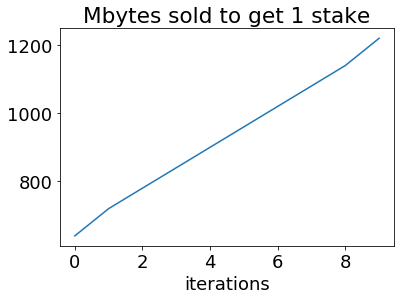

In [24]:
mb_sold_to_stake = costs_to_stake / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_stake)
ax.set(xlabel='iterations', title='Mbytes sold to get 1 stake')
plt.show()

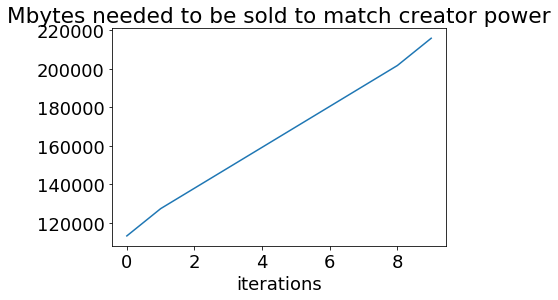

In [25]:
mb_sold_to_match_creator = costs_to_match_creator / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_match_creator)
ax.set(xlabel='iterations', title='Mbytes needed to be sold to match creator power')
plt.show()

In [26]:
print(f"• The creator has {int(CREATOR_BLOCK_SIZE/params['stake'])} stakes of voting power")

listings_approved_to_match_creator = CREATOR_BLOCK_SIZE / params['list_reward']
print(f"• It takes {int(listings_approved_to_match_creator)} listings to match creator voting power")

• The creator has 176 stakes of voting power
• It takes 353945 listings to match creator voting power
